# Dirichlet process mixture models

[Bayesian mixture models](bayesian_mixture_models.ipynb) introduced how to infer the posterior of the parameters of a mixture model with a fixed number of components $K$. We can either find $K$ using model selection, i.e. with AIC, BIC, WAIC, etc., or try to automatically infer this number. Nonparametric mixture models do exactly this. 

Here we implement a nonparametric Bayesian mixture model for Gaussian random variables using a *Chinese restaurant process* prior and using *stick-breaking* construction. Both create samples from a *Dirichlet process* (see for instance Nils Hjort's [*Bayesian Nonparametrics*](https://www.cambridge.org/ch/academic/subjects/statistics-probability/statistical-theory-and-methods/bayesian-nonparametrics?format=HB&isbn=9780521513463), Peter Orbanz' [lecture notes](http://stat.columbia.edu/~porbanz/papers/porbanz_BNP_draft.pdf)), Kevin Murphy's [book](https://mitpress.mit.edu/books/machine-learning-1) and last but not least Herman Kamper's [notes](https://www.kamperh.com/notes/kamper_bayesgmm13.pdf).

**As usual I do not take warranty for the correctness or completeness of this document.**

In [7]:
options(repr.fig.width=4, repr.plot.height=3)

## The Dirichlet process

The DP, as any BNP model, puts priors on structures that accomodate infinite sizes. The resulting posteriors give a distribution on structures that grow with new observations.

## The Chinese restaurant process

The Chinese restaurant process (CRP) is possibly the simplest case which models a distribution over partitions as prior clustering. We will first discuss how a latent CRP creates the data and then use collapsed GIbbs sampling to infer the parameters of a Gaussian DPMM.

### Data generating process

Assuming normally distributed data the CRP model is:

1. Draw the parameters of each Gaussian component:
\begin{align*}
\theta_k \sim \mathcal{N}(0, \lambda)
\end{align*}
2. For each datum $i$:
    1. Draw cluster assignment: $z_i \mid z_{1:i-1} \sim \text{CRP}(\alpha)$
    2. Draw $x_i \sim \mathcal{N}(\theta_{z_i}, \sigma^2)$
    
Above we assumed a conjugate distribution for the means $\theta_k$ and known identical variance for every component.
Let's go through that below once.

Load `e1071` to sample class labels (i.e. multinoulli).

In [1]:
library("e1071")
library("mvtnorm")
set.seed(23)

Set a number of data points and the concentration of the Dirichlet Process.

In [2]:
n <- 100
alpha <- .5

Latent class assignments (`Z`), the current table index and the number of customers per table.

In [3]:
Z <- integer(n)
X <- matrix(0, n, 2)
curr.tab <- 0
tables <- c()

In [4]:
sigma <- .1
mus <- NULL

Create a random assignment of customers to tables with probability $P(z_i \mid Z_{-i})$.

In [5]:
for (i in seq(n))
{   
    probs <- c(tables / (i - 1 + alpha), alpha / (i - 1 + alpha))
    table <- rdiscrete(1, probs)
    if (table > curr.tab) 
    {
        curr.tab <- curr.tab + 1
        tables <- c(tables, 0)
        mu <- mvtnorm::rmvnorm(1, c(0, 0), 10 * diag(2))
        mus <- rbind(mus, mu)
    }
    Z[i] <- table
    X[i,] <- mvtnorm::rmvnorm(1, mus[Z[i], ], sigma * diag(2))
    tables[table] <-  tables[table] + 1
}

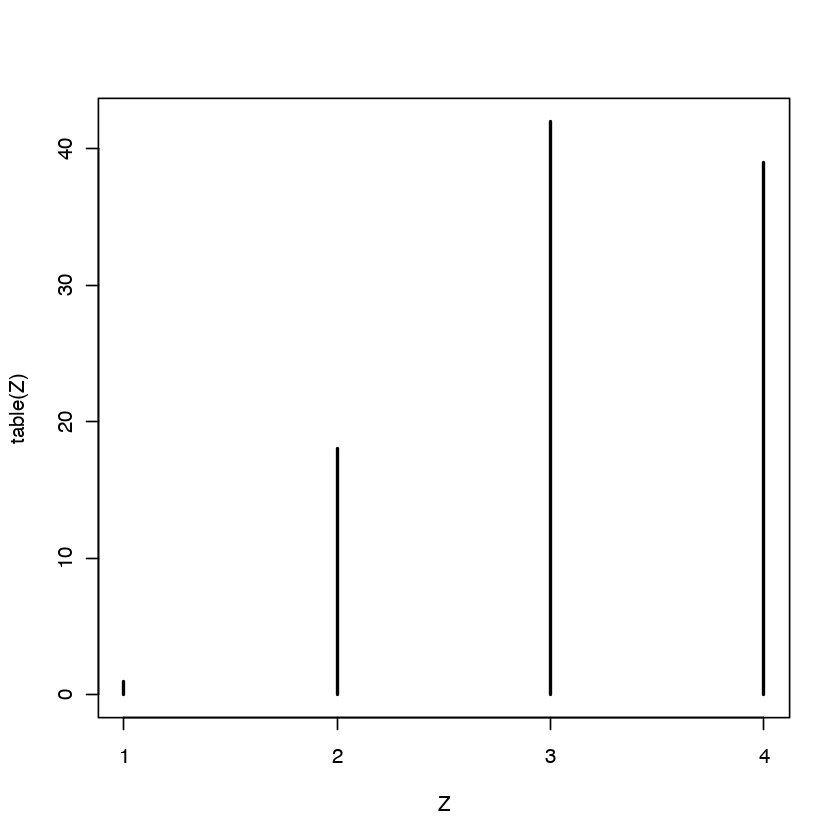

In [6]:
plot(table(Z))

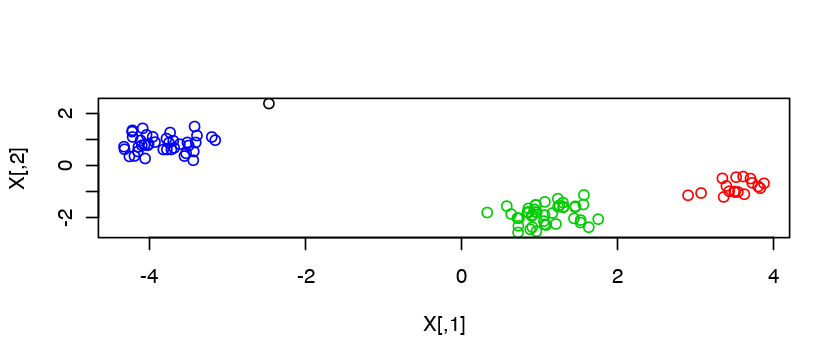

In [8]:
plot(X, col=Z)

### Posterior inference using collapsed Gibbs sampling

Using conjugate prior distributions we can use *collapsed Gibbs sampling* for inference of the class assignments.

In [95]:
p <- 2
mu0 <- c(0, 0)
Sigma0 <- .1 * diag(2)
prec0 <- solve(Sigma0)
G0 <- mvtnorm::rmvnorm

In [96]:
mus <- matrix(0, 1, 2)
sigma <- .1 * diag(p)
prec <- solve(sigma)

In [97]:
remove_xi <- function(i)
{
    zi <- Z[i]
    tables[zi] <<- tables[zi] - 1
    C[zi, i] <<- 0
    
    if (tables[zi] == 0) {
        K <<- K - 1
        Z[Z > zi] <<- Z[Z > zi] - 1
        C <<- C[-zi,]
        tables <<- tables[-zi]
        mus <<- mus[-zi, ]
    }
}

In [98]:
add_xi <- function(i, k)
{
    if (k > K) {
        K <<- K + 1
        tables <<- c(tables, 0)
        C <<- rbind(C, 0)
        mus <<- rbind(mus, G0(1, m0, Sigma0))
    }
    
    Z[i] <<- k
    C[k, i] <<- 1
    tables[k] <<- tables[k] + 1
}

In [99]:
mvt <- function(X=NULL, skip=FALSE)
{    
    kn <- 2
    nun <- 2
    if (!skip) {
        X.bar <- apply(X, 2, mean, na.rm=TRUE)
        n <- nrow(X)
        kn <- kn + n
        nun <- nun + n
        mn <- (m0 + n * X.bar) / kn
        Sn <- Sigma0 + t(X) %*% X + m0 %*% t(m0)# - mn %*% t(mn)
    } else {
        X.bar <- rep(0, p)    
        n <- 0
        mn <- m0
        Sn <- Sigma0
    }
    
    Sn.mvt <- (kn + 1) / (kn * (nun - p + 1)) * Sn
    mvtnorm::pmvt(1, df = nun - p + 1, sigma = Sn.mvt, delta = mn)
}

In [100]:
sample_params <- function()
{
    for (k in seq(K)) {
        xk <- X[Z == k, ,drop=FALSE]
        
        tables[k] <<- nrow(xk)
        
        la <- prec0 + tables[k] * prec
        co <- solve(la)
        
        mu <- co %*% prec0 %*% mu0 + tables[k] * prec %*% apply(xk, 2, mean)
        
        mus[k, ] <<- mvtnorm::rmvnorm(1, mu, co)
    }
}

In [101]:
alpha <- 1

In [102]:
# initialization of the cluster assignments
Z <- rep(1, n)
# customers per table
tables <- n
# number.of.clusters
K <- 1
# cluster matrix
C <- matrix(1, K, n)

for (iter in seq(10))
{
   for (i in seq(n))
   {
        remove_xi(i)
        zi <- Z[i]

        # compute posterior probabilitites for joining a table
        Z_no_i <- Z[-i]
        p_zi <- rep(0, K + 1)
        for (k in seq(K)) {
            # prior P(z_i | z_-i)
            crp <- sum(Z_no_i == k) / (n + alpha - 1)
            lik <- mvtnorm::dmvnorm(X[i, ], mus[k,], sigma)

            # compute likelihood P(x_i | x_-i)
            # p_zi[k] <- crp * mvt(X[which(Z == k)[-i],,drop=FALSE])
            p_zi[k] <- crp * lik
        }
       
        # compute probability for opening up a new one
        #p_zi[K + 1] <- alpha / (n + alpha - 1) * mvt(NULL, skip=TRUE)
        p_zi[K + 1] <- alpha / (n + alpha - 1) * mvtnorm::dmvnorm(X[i, ], mu0, Sigma0 + sigma)
        p_zi <- p_zi / sum(p_zi)

        # sample new Z
        z_new <- rdiscrete(1, probs = p_zi)
        add_xi(i, z_new)
       
       sample_params()
    }
}

Let;s see if that worked out!

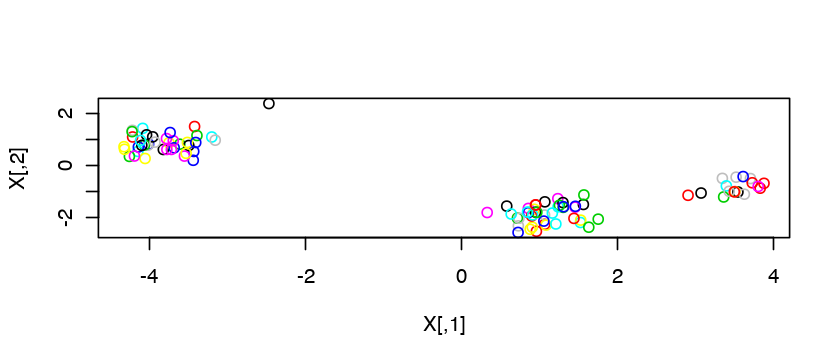

In [103]:
plot(X, col=Z)

We can do the same think in `greta`

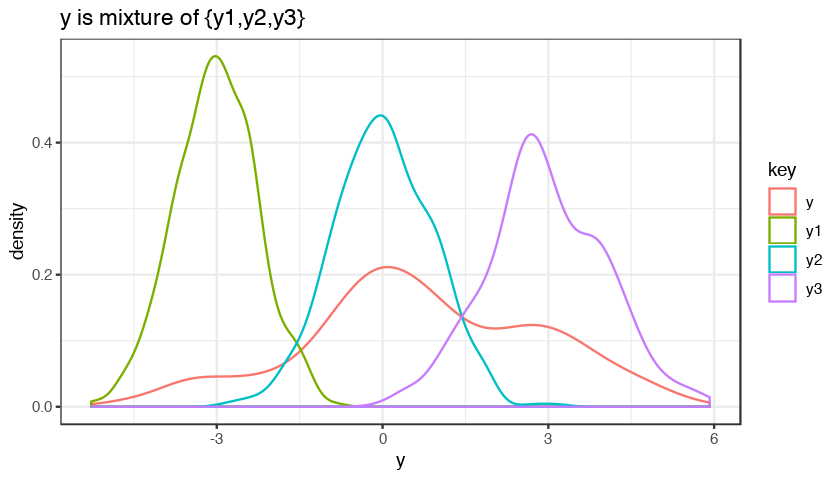

In [145]:
dat %>% 
gather(key, value) %>%
ggplot( aes(value)) + 
geom_density(aes(color = key)) + 
    theme_bw() + xlab("y") + ggtitle("y is mixture of {y1,y2,y3}")

In [ ]:
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

stan_model <- "
data{
  int<lower=0> C;//num of cludter
  int<lower=0> N;//data num
  real y[N];
}

parameters {
  real mu_cl[C]; //cluster mean
  real <lower=0,upper=1> v[C];
  real<lower=0> sigma_cl[C]; // error scale
  //real<lower=0> alpha; // hyper prior DP(alpha,base)
}

transformed parameters{
  simplex [C] pi;
  pi[1] = v[1];
  // stick-break process based on The BUGS book Chapter 11 (p.294)
  for(j in 2:(C-1)){
      pi[j]= v[j]*(1-v[j-1])*pi[j-1]/v[j-1]; 
  }
  pi[C]=1-sum(pi[1:(C-1)]); // to make a simplex.
}

model {
  real alpha = 1;
  real a=0.001;
  real b=0.001;
  real ps[C];
  sigma_cl ~ inv_gamma(a,b);
  mu_cl ~ normal(0,5);
  //alpha~gamma(6,1);
  v ~ beta(1,alpha);
  
  for(i in 1:N){
    for(c in 1:C){
      ps[c]=log(pi[c])+normal_lpdf(y[i]|mu_cl[c],sigma_cl[c]);
    }
    target += log_sum_exp(ps);
  }

}
"
y <- dat$y
C <- 10  # to ensure large enough
N <- length(y)
input_dat <- list(y = y, N = N, C = C)
# model_object<-stan_model(model_code=stan_model)
fit <- stan(model_code = stan_model, data = input_dat, iter = 1000, chains = 1)
results <- rstan::extract(fit)

In [146]:
y <- dat$y
C <- 10
N <- length(y)
input_dat <- list(y = y, N = N, C = C)
fit <- stan(model_code = stan_model, data = input_dat, iter = 1000, chains = 1)
results <- rstan::extract(fit)

Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Attaching package: ‘rstan’

The following object is masked from ‘package:magrittr’:

    extract

The following object is masked from ‘package:tidyr’:

    extract



In file included from file2434354ece5e.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/core.hpp:14:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/core/matrix_vari.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/mat/fun/Eigen_NumTraits.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/prim/mat/fun/Eigen.hpp

Warning message:
“There were 479 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [147]:
plot_dat_pi <- data.frame(results$pi) %>% 
    as_data_frame() %>% 
    set_names(sprintf("pi%02d", 1:10)) 

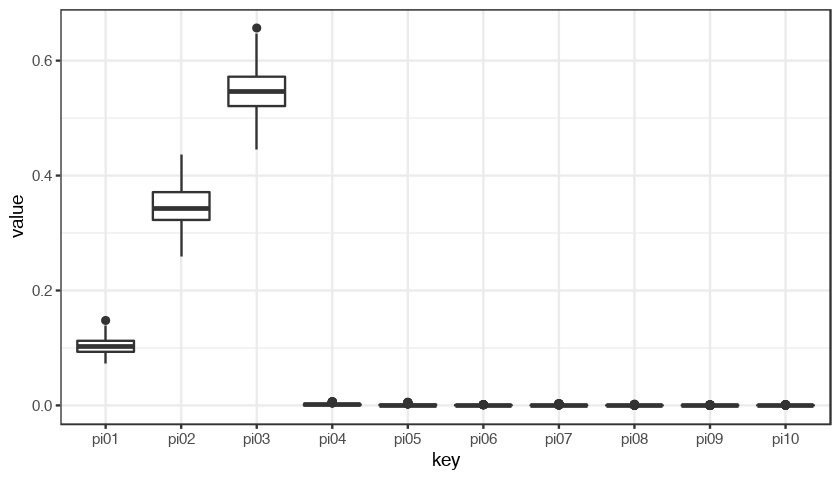

In [148]:
plot_dat_pi %>% 
    gather(key, value) %>%
    ggplot(aes(x = key, y = value)) + 
    geom_boxplot() + 
    theme_bw()


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



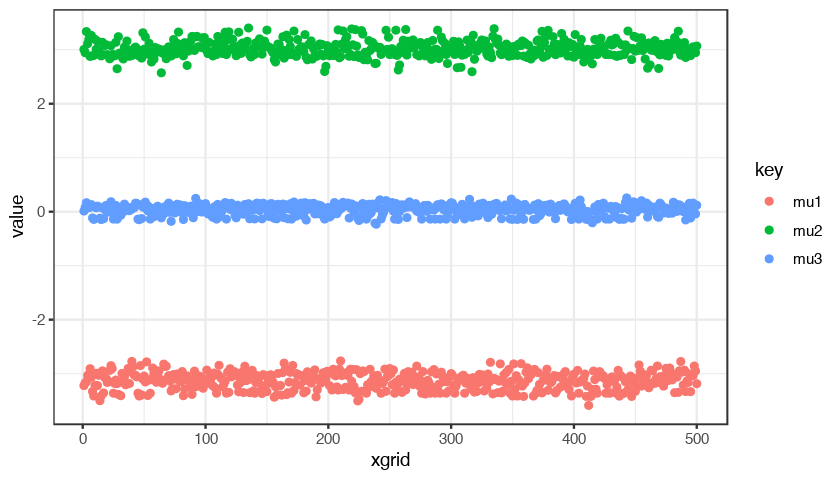

In [149]:
library(gridExtra)
plot_mu_dat <- data.frame(results$mu_cl[, 1:3]) %>% as_data_frame() %>% set_names(sprintf("mu%d", 
    1:3))
plot_mu_dat %<>% mutate(xgrid = (1:length(plot_mu_dat$mu1)))
ggplot(plot_mu_dat %>% gather(key, value, mu1:mu3), aes(x = xgrid, y = value, 
    color = key)) + geom_point() + theme_bw()